In [1]:
%cd ../..

c:\Boyko Boev\Stock-Market-Prediction\src


c:\Boyko Boev\Stock-Market-Prediction\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.cnn_v3.cnn_model import build_model, train_model, save_cnn_model, load_cnn_model
from models.cnn_v3.cnn_normalize import get_cnn_data, get_images_dataset, get_classes_and_files
from utils.chart import config_chart, plot_model_performance, plot_scatter_data, plot_distribution_data, plot_direction_comparison
from constants import SP500_TICKER, NASDAQ_TICKER, DJI_TICKER
from sklearn.metrics import accuracy_score


---

## For **build_model** function

In [3]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 253, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 250, 16)        │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 250, 247, 8)         │           1,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 494000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │      15,808,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,817,469 (60.34 MB)

 Trainable params: 15,817,469 (60.34 MB)

 Non-trainable params: 0 (0.00 B)

---

## For **train_model** function

In [4]:
# nasdaq_train, nasdaq_test, nasdaq_predict= get_cnn_data(NASDAQ_TICKER)
train, test, predict = get_cnn_data(NASDAQ_TICKER)

x_train = train["x"] 
y_train = train["y"]

x_test = test["x"]
y_test = test["y"]

x_predict = predict["x"]
y_predict = predict["y"]


print("Train data:")
print(x_train.shape)
print(y_train.shape)

print("Test data:")
print(x_test.shape)
print(y_test.shape)

print("Predict data:")
print(x_predict.shape)
print(y_predict.shape)

Train data:
(1584, 256, 256, 4)
(1584,)
Test data:
(198, 256, 256, 4)
(198,)
Predict data:
(198, 256, 256, 4)
(198,)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - accuracy: 0.4859 - loss: 8.5208
Epoch 2/10


C:\Programs\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.5213 - loss: 1.2993
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.6032 - loss: 1.0923
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 436ms/step - accuracy: 0.7926 - loss: 0.5702
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.8567 - loss: 0.4258
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 544ms/step - accuracy: 0.8988 - loss: 0.2869
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - accuracy: 0.9133 - loss: 0.2371
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.9771 - loss: 0.0952
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 549ms/step - accuracy: 0.9911 - loss: 0.0387
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 474ms/step - accuracy: 0.9953 - loss: 0.0208
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6819 - loss: 1.8626


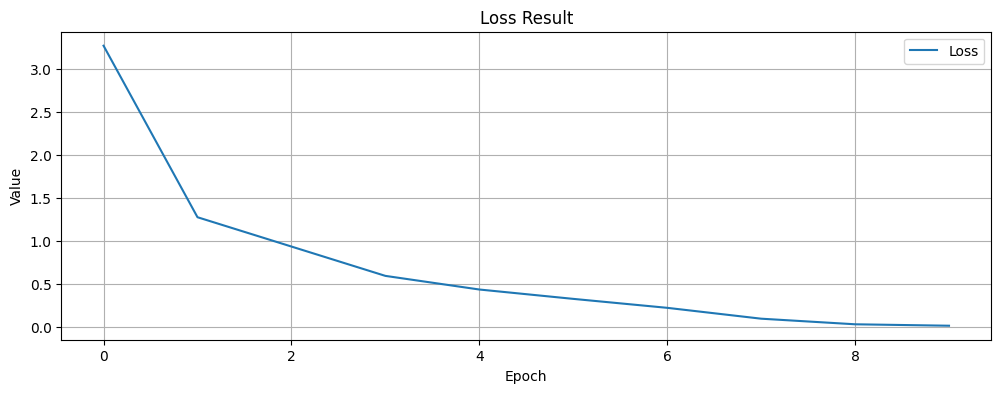

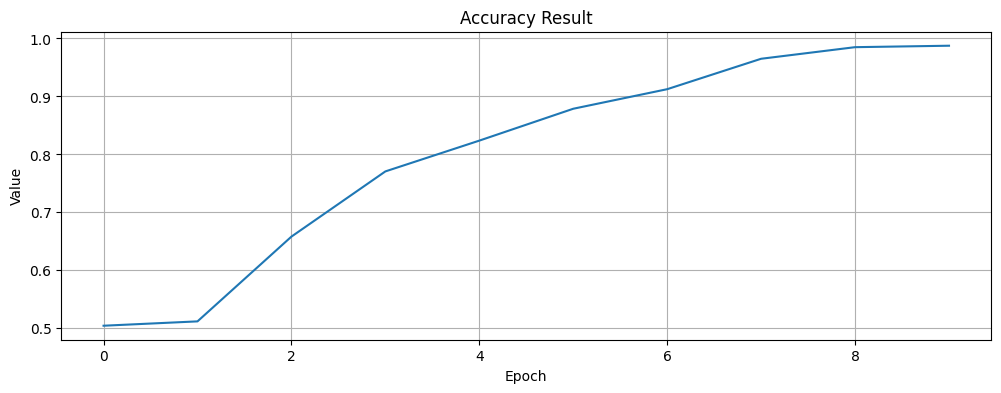

Train result:
Test result:
[1.8916330337524414, 0.6717171669006348]


In [5]:
model, fit_result, evaluate_result = train_model(x_train, x_test, y_train, y_test) 

plot_model_performance(fit_result)

print("Train result:")
print(fit_result)

print("Test result:")
print(evaluate_result)

save_cnn_model(model)

In [6]:
latest_train_metrics = [value[-1] for key, value in fit_result.history.items()]

print("Train result:")
print("accuracy, loss")
print(latest_train_metrics)

print("Test result:")
print("loss, accuracy")
print(evaluate_result)

Train result:
accuracy, loss
[0.987500011920929, 0.014136441983282566]
Test result:
loss, accuracy
[1.8916330337524414, 0.6717171669006348]


In [7]:
model = load_cnn_model()

In [8]:
predictions_train = model.predict(x_train)

predicted_classes = np.argmax(predictions_train, axis=1)

accuracy = accuracy_score(y_train, predicted_classes)
print("Accuracy:", accuracy)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step
Accuracy: 0.9987373737373737


In [9]:
predictions_test = model.predict(x_test)

predicted_classes = np.argmax(predictions_test, axis=1)

accuracy = accuracy_score(y_test, predicted_classes)
print("Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Accuracy: 0.6717171717171717


In [10]:
predictions = model.predict(x_predict)

predicted_classes = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_predict, predicted_classes)
print("Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Accuracy: 0.6767676767676768


['bearish_reverse' 'bearish_trend' 'bullish_reverse' 'bullish_trend'
 'neutral']
[4.67740247e-09 2.66047395e-15 1.04685434e-07 9.99999881e-01
 2.84764194e-08]
Actual Result: bullish_trend
Predicted Result: bullish_trend


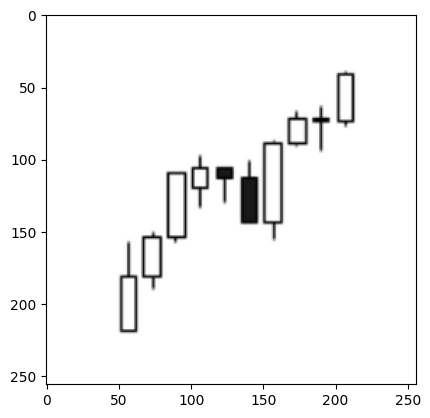

In [11]:
index = 20

classes, _ = get_classes_and_files()

print(classes)
print(predictions[index])
print("Actual Result:", classes[y_predict[index]])
print("Predicted Result:", classes[predicted_classes[index]])

img = predicted_classes[index]
plt.imshow(x_predict[index])